# Air pollution GRU and LSTM model

In [47]:
import os
import pandas as pd
import numpy as np
# PyTorch
import torch
import torch.nn as nn
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# Ray
from ray.train.lightning import (
    RayDDPStrategy,
    RayLightningEnvironment,
    RayTrainReportCallback,
    prepare_trainer,
)
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.train import RunConfig, ScalingConfig, CheckpointConfig
from ray.train.torch import TorchTrainer
# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
# Visualization
import seaborn as sn
sn.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Plot the loss curve based on the latest file from lightning logs
def plot_loss_curve():
    latest_file = os.path.join(max([os.path.join("/home/maciej/Uni/Studia II stopień/II rok/Machine Learning 2/GRU-ML-presentation/lightning_logs", f) 
                                    for f in os.listdir("lightning_logs")], 
                                    key=os.path.getctime), "metrics.csv")
    loss_data = pd.read_csv(latest_file)
    loss_data['val_loss'] = loss_data.val_loss.shift(1)
    loss_data = loss_data[["epoch", "train_loss", "val_loss"]].dropna()
    loss_data['epoch'] = loss_data.epoch.map(lambda x: x+1)

    plt.plot(loss_data['epoch'], loss_data['train_loss'], label="Training loss")
    plt.plot(loss_data['epoch'], loss_data['val_loss'], label = "Validation loss")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss metric")
    plt.xticks(loss_data['epoch'])
    plt.legend(loc="upper right")
    plt.show()

## Exploring the dataset

In [3]:
pollution_df  = pd.read_csv("data/LSTM-Multivariate_pollution.csv")
pollution_test_df  = pd.read_csv("data/pollution_test_data1.csv")

In [81]:
pollution_df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [82]:
pollution_df.shape

(43800, 9)

In [83]:
pollution_df.dtypes

date          object
pollution    float64
dew            int64
temp         float64
press        float64
wnd_dir       object
wnd_spd      float64
snow           int64
rain           int64
dtype: object

In [84]:
pollution_df.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [34]:
pollution_df.groupby("wnd_dir").wnd_dir.count()

wnd_dir
NE     4996
NW    14130
SE    15290
cv     9384
Name: wnd_dir, dtype: int64

In [27]:
pollution_df.isna().sum()

date         0
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

## Visualization

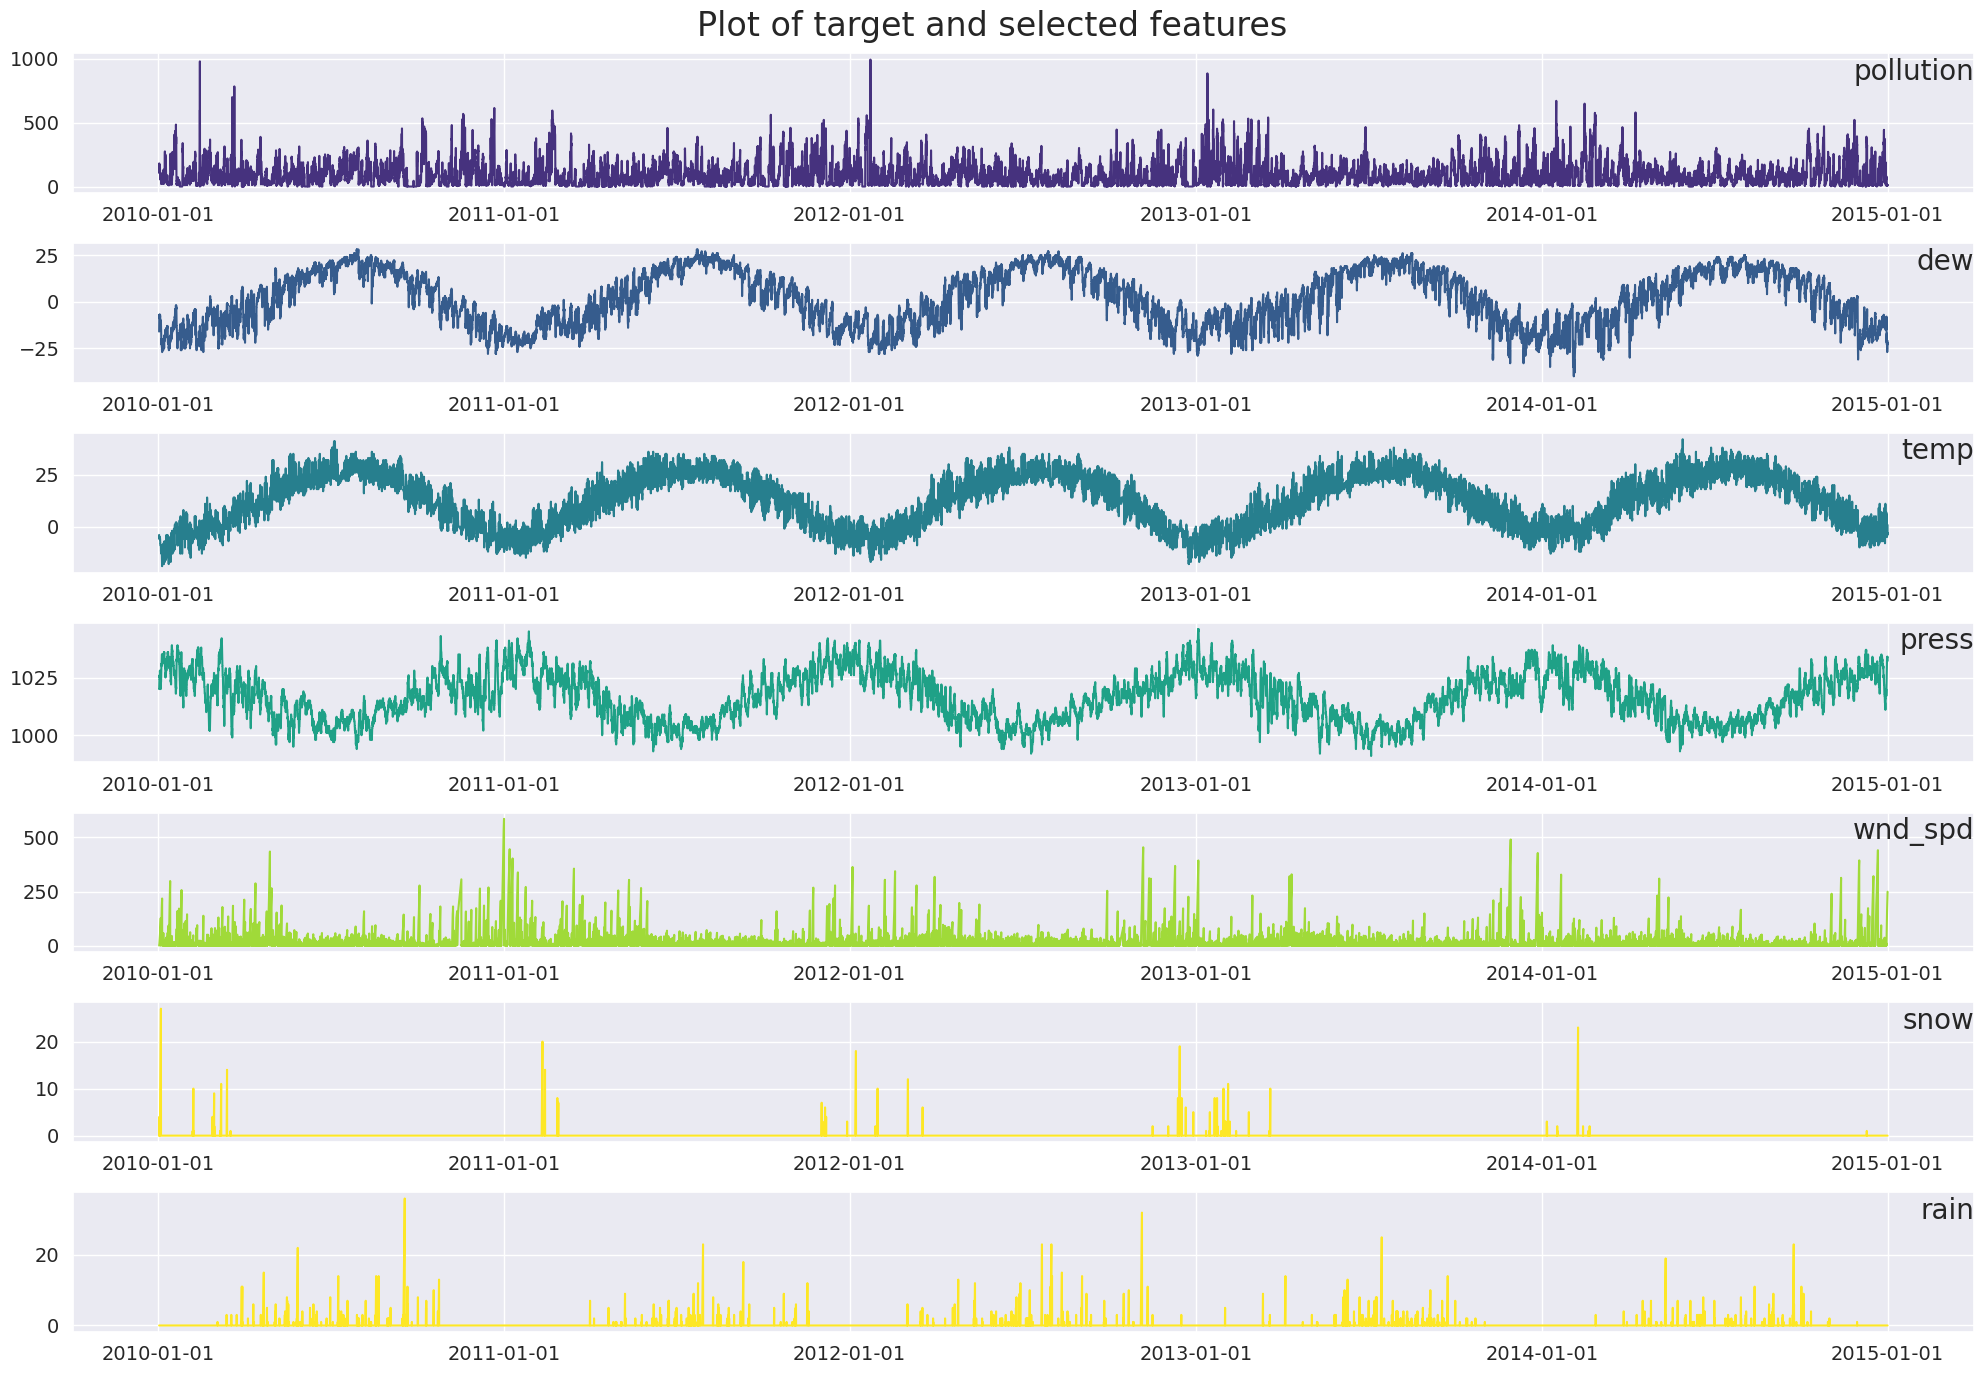

In [8]:
# Visualizing the numerical values
values = pollution_df.values
dates = [datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S') for date_str in values[:,0]]

groups = [1, 2, 3, 4, 6, 7, 8]
i = 1

fig, axs = plt.subplots(len(groups), 1, figsize=(20, 14), facecolor='white')
for group, ax in zip(groups, axs):
    ax.plot(dates, values[:, group], color=cm.viridis(group/len(groups)))
    ax.set_title(pollution_df.columns[group], y=0.75, loc='right', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    i += 1

plt.suptitle('Plot of target and selected features', fontsize=24)
plt.tight_layout()
plt.show()

## Pytorch codes

### Custom dataset class

In [4]:
# Custom dataset class for pollution data
class PollutionData(Dataset):
    def __init__(self, X, y, seq_len, device=device):
        # Features and targets
        self.X = X
        self.y = y
        # Length of sequence
        self.seq_len = seq_len
        # Chosen device
        self.device = device

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Concatenate X and y to use target lags as input
        X_sample = np.concatenate([self.X, self.y], axis=1)
        
        # If the index is lower than sequence length, then apply padding
        # The data used for prediction should reach until 24h before the prediction
        # It will make more sense to be able to predict the pollution 24h from now than 1h from now
        if idx >= self.seq_len:
            X_sample = X_sample[(idx - self.seq_len):idx]      
        else:
            X_sample = X_sample[:idx]
            padding = np.zeros((self.seq_len - idx, X_sample.shape[1]))
            X_sample = np.concatenate([padding, X_sample], axis = 0)
        
        return torch.tensor(X_sample).to(torch.float32).to(self.device), torch.tensor(self.y[idx]).to(torch.float32).to(self.device)

### Lightning dataloader

In [5]:
# Custom lightning dataloader
class PollutionDataLoader(L.LightningDataModule):
    def __init__(self, train_dir, test_dir, seq_len, X_scaler, y_scaler, test_size, random_state, batch_size, num_workers, device):
        super().__init__()
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.seq_len = seq_len
        self.X_scaler = X_scaler
        self.y_scaler = y_scaler
        self.test_size = test_size
        self.random_sate = random_state
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.device = device
        self.train_df = None
        self.test_df = None
        self.X_train = None
        self.y_train = None
        self.X_val = None
        self.y_val = None
        self.X_test = None
        self.y_test = None
        self.pollution_train = None
        self.pollution_val = None
        self.pollution_test = None

    def setup(self, stage):
        # Load the training dataset
        self.train_df = pd.read_csv(self.train_dir)
        # Load the test dataset
        self.test_df = pd.read_csv(self.test_dir)
        # Map the categories of wind direction to numeric values
        mapping = {"NE": 0, "NW": 1, "SE": 2, "cv": 3}
        self.train_df["wnd_dir"] = self.train_df.wnd_dir.map(mapping)
        self.test_df["wnd_dir"] = self.test_df.wnd_dir.map(mapping)
        # Create X and y by dropping date and seperating features and target
        X = self.train_df.drop(["date", "pollution"], axis=1)
        # Shift features by 24, because we want to predict pollution in 24h
        X = X.shift(periods=24, fill_value=0)
        y = self.train_df[["pollution"]]
        self.X_test = self.test_df.drop(["pollution"], axis=1)
        self.y_test = self.test_df[["pollution"]]
        # Apply train test split
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X
                                                                              , y
                                                                              , test_size=self.test_size
                                                                              , shuffle=False
                                                                              , random_state=self.random_sate
                                                                              )
        
        # Transform with scaler if provided
        if self.X_scaler and self.y_scaler:
            self.X_train = self.X_scaler.fit_transform(self.X_train)
            self.X_val = self.X_scaler.transform(self.X_val)
            self.X_test = self.X_scaler.transform(self.X_test)
            self.y_train = self.y_scaler.fit_transform(self.y_train)
            self.y_val = self.y_scaler.transform(self.y_val)
            self.y_test = self.y_scaler.transform(self.y_test)

        # Create two instances of the custom dataset class
        self.pollution_train = PollutionData(self.X_train
                                             , self.y_train
                                             , seq_len=self.seq_len
                                             , device=self.device
                                             )
        self.pollution_val = PollutionData(self.X_val
                                           , self.y_val
                                           , seq_len=self.seq_len
                                           , device=self.device
                                             )
        self.pollution_test = PollutionData(self.X_test
                                            , self.y_test
                                            , seq_len=self.seq_len
                                            , device=self.device
                                            )

    def train_dataloader(self):
        # Return the dataloader of train data
        return DataLoader(self.pollution_train
                          , shuffle=True
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )

    def val_dataloader(self):
        # Return the dataloader of validation data
        return DataLoader(self.pollution_val
                          , shuffle=False
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )

    def test_dataloader(self):
        # Return the dataloader of test data
        return DataLoader(self.pollution_test
                          , shuffle=False
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          )

### LSTM model class

In [11]:
# LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, in_size, h_size, num_l, out_f, dropout_rate):
        super().__init__()
        self.input_size = in_size
        self.hidden_size = h_size
        self.num_layers = num_l
        self.out_features = out_f
        self.dropout_rate = dropout_rate
        self.lstm = nn.LSTM(input_size=self.input_size
                            , hidden_size=self.hidden_size
                            , num_layers=self.num_layers
                            , batch_first=True
                            , dropout=self.dropout_rate
                            )
        self.linear1 = nn.Linear(in_features=self.hidden_size
                                 , out_features=self.out_features)
        self.relu = nn.ReLU()
    
    def forward(self, X):
        X, _ = self.lstm(X)
        X = self.linear1(X[:,-1,:])
        X = self.relu(X)

        return X

### GRU model class

In [12]:
# GRU model class
class GRUModel(nn.Module):
    def __init__(self, in_size, h_size, num_l, out_f, dropout_rate):
        super().__init__()
        self.input_size = in_size
        self.hidden_size = h_size
        self.num_layers = num_l
        self.out_features = out_f
        self.dropout_rate = dropout_rate
        self.lstm = nn.GRU(input_size=self.input_size
                           , hidden_size=self.hidden_size
                           , num_layers=self.num_layers
                           , batch_first=True
                           , dropout=self.dropout_rate
                           )
        self.linear1 = nn.Linear(in_features=self.hidden_size
                                 , out_features=self.out_features
                                 )
        self.relu = nn.ReLU()
    
    def forward(self, X):
        X, _ = self.lstm(X)
        X = self.linear1(X[:,-1,:])
        X = self.relu(X)

        return X

### PyTorch Lightning time-series model class

In [13]:
# Time-series model created with lightning
class TSModel(L.LightningModule):
    def __init__(self, model, lr=0.01):
        super().__init__()
        # Model of choice (either LSTM or GRU)
        self.model = model
        # Learning rate
        self.lr = lr

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        train_loss = F.mse_loss(y_pred, y)
        self.log("train_loss", train_loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        val_loss = F.mse_loss(y_pred, y)
        self.log("val_loss", val_loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        test_loss = F.mse_loss(y_pred, y)
        self.log("test_loss", test_loss, sync_dist=True)
    
    def predict_step(self, batch, batch_id):
        X, y = batch
        y_pred = self.model(X)

        return y_pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

### Ray tuner

In [11]:
# Function for training model with Ray tuner
def lstm_train_func(config):
    dm = PollutionDataLoader(train_dir="/home/maciej/Uni/Studia II stopień/II rok/Machine Learning 2/GRU-ML-presentation/data/LSTM-Multivariate_pollution.csv"
                             , test_dir="/home/maciej/Uni/Studia II stopień/II rok/Machine Learning 2/GRU-ML-presentation/data/pollution_test_data1.csv"
                             , seq_len=config["seq_len"]
                             , X_scaler=MinMaxScaler()
                             , y_scaler=MinMaxScaler()
                             , test_size=0.3
                             , random_state=42
                             , batch_size=config["batch_size"]
                             , num_workers=7
                             , device=device
                             )
    torch_model = LSTMModel(in_size=8
                            , h_size=config["h_size"]
                            , num_l=config["num_l"]
                            , out_f=1
                            , dropout_rate=config['dropout_rate']).to(device)
    model = TSModel(torch_model, lr=config['lr'])

    trainer = L.Trainer(
        max_epochs=10,
        devices="auto",
        accelerator="auto",
        strategy=RayDDPStrategy(),
        callbacks=[RayTrainReportCallback()],
        plugins=[RayLightningEnvironment()],
        enable_progress_bar=True,
    )
    trainer = prepare_trainer(trainer)
    trainer.fit(model, datamodule=dm)

# Function for training model with Ray tuner
def gru_train_func(config):
    dm = PollutionDataLoader(train_dir="/home/maciej/Uni/Studia II stopień/II rok/Machine Learning 2/GRU-ML-presentation/data/LSTM-Multivariate_pollution.csv"
                             , test_dir="/home/maciej/Uni/Studia II stopień/II rok/Machine Learning 2/GRU-ML-presentation/data/pollution_test_data1.csv"
                             , seq_len=config["seq_len"]
                             , X_scaler=MinMaxScaler()
                             , y_scaler=MinMaxScaler()
                             , test_size=0.3
                             , random_state=42
                             , batch_size=config["batch_size"]
                             , num_workers=7
                             , device=device
                             )
    torch_model = GRUModel(in_size=8
                           , h_size=config["h_size"]
                           , num_l=config["num_l"]
                           , out_f=1
                           , dropout_rate=config['dropout_rate']).to(device)
    model = TSModel(torch_model, lr=config['lr'])

    trainer = L.Trainer(
        max_epochs=10,
        devices="auto",
        accelerator="auto",
        strategy=RayDDPStrategy(),
        callbacks=[RayTrainReportCallback()],
        plugins=[RayLightningEnvironment()],
        enable_progress_bar=True,
    )
    trainer = prepare_trainer(trainer)
    trainer.fit(model, datamodule=dm)

In [12]:
# The search space
search_space = {
    "seq_len": tune.choice([12, 24, 48])
    , "h_size": tune.choice([4, 8, 16, 32])
    , "num_l": tune.choice([4, 8, 16, 32])
    , "dropout_rate": tune.choice([0.2, 0.4])
    , "lr": tune.loguniform(1e-4, 1e-1)
    , "batch_size": tune.choice([64, 128, 256])
}

In [13]:
scaling_config = ScalingConfig(
    num_workers=7, use_gpu=False
)

run_config = RunConfig(
    checkpoint_config=CheckpointConfig(
        num_to_keep=2,
        checkpoint_score_attribute="val_loss",
        checkpoint_score_order="min",
    ),
)

In [14]:
ray_trainer = TorchTrainer(
    lstm_train_func,
    scaling_config=scaling_config,
    run_config=run_config,
)

In [15]:
def tune_pollution_asha(num_samples=10):
    scheduler = ASHAScheduler(max_t=10, grace_period=1, reduction_factor=2)

    tuner = tune.Tuner(
        ray_trainer,
        param_space={"train_loop_config": search_space},
        tune_config=tune.TuneConfig(
            metric="val_loss",
            mode="min",
            num_samples=num_samples,
            scheduler=scheduler,
        ),
    )
    return tuner.fit()

In [16]:
L.seed_everything(42, workers=True)

lstm_search_results = tune_pollution_asha(num_samples=10)
lstm_search_results.get_best_result(metric="val_loss", mode="min")

(TorchTrainer pid=19924) Starting distributed worker processes: ['19974 (192.168.1.17)', '19975 (192.168.1.17)', '19976 (192.168.1.17)', '19977 (192.168.1.17)', '19978 (192.168.1.17)', '19979 (192.168.1.17)', '19980 (192.168.1.17)']
(RayTrainWorker pid=19974) Setting up process group for: env:// [rank=0, world_size=7]
(RayTrainWorker pid=19974) GPU available: False, used: False
(RayTrainWorker pid=19974) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=19974) IPU available: False, using: 0 IPUs
(RayTrainWorker pid=19974) HPU available: False, using: 0 HPUs
(RayTrainWorker pid=19974) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, un

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]
                                                                           
Epoch 0: 100%|██████████| 69/69 [00:30<00:00,  2.23it/s, v_num=0]
(RayTrainWorker pid=19974) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:   0%|          | 0/30 [00:00<?, ?it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:   3%|▎         | 1/30 [00:00<00:06,  4.70it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:   7%|▋         | 2/30 [00:00<00:05,  5.31it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  10%|█         | 3/30 [00:00<00:04,  5.80it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  13%|█▎        | 4/30 [00:00<00:04,  5.97it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  17%|█▋        | 5/30 [00:00<00:04,  5.97it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  20%|██     

(RayTrainWorker pid=19976) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00000_0_batch_size=64,dropout_rate=0.2000,h_size=32,lr=0.0157,num_l=4,seq_len=48_2023-11-21_23-48-05/checkpoint_000000)
(RayTrainWorker pid=19975) [rank: 1] Seed set to 42 [repeated 6x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(RayTrainWorker pid=19979) Missing logger folder: /home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00000_0_batch_size=64,dropout_rate=0.2000,h_size=32,lr=0.0157,num_l=4,seq_len=48_2023-11-21_23-48-05/lightning_logs [repeated 6x across cluster]
(RayTrainWorker pid=19980) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoad

Epoch 1: 100%|██████████| 69/69 [00:34<00:00,  2.01it/s, v_num=0, val_loss=0.00166, train_loss=0.0085]
(RayTrainWorker pid=19974) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:   0%|          | 0/30 [00:00<?, ?it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:   3%|▎         | 1/30 [00:00<00:06,  4.74it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:   7%|▋         | 2/30 [00:00<00:05,  5.27it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  10%|█         | 3/30 [00:00<00:04,  5.78it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  13%|█▎        | 4/30 [00:00<00:04,  6.06it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  17%|█▋        | 5/30 [00:00<00:03,  6.51it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  20%|██        | 6/30 [00:00<00:03,  6.25it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  23%|██▎       | 7/30 [00:01<00:03,  5.90it/s]
(RayTrainWorker pid=19974) 
Val

(RayTrainWorker pid=19974) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00000_0_batch_size=64,dropout_rate=0.2000,h_size=32,lr=0.0157,num_l=4,seq_len=48_2023-11-21_23-48-05/checkpoint_000001) [repeated 7x across cluster]


Epoch 2: 100%|██████████| 69/69 [00:26<00:00,  2.56it/s, v_num=0, val_loss=0.000728, train_loss=0.00157]
(RayTrainWorker pid=19974) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:   0%|          | 0/30 [00:00<?, ?it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:   3%|▎         | 1/30 [00:00<00:07,  4.08it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:   7%|▋         | 2/30 [00:00<00:06,  4.47it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  10%|█         | 3/30 [00:00<00:05,  4.57it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  13%|█▎        | 4/30 [00:00<00:05,  5.04it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  17%|█▋        | 5/30 [00:00<00:04,  5.46it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  20%|██        | 6/30 [00:01<00:04,  5.12it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  23%|██▎       | 7/30 [00:01<00:04,  4.71it/s]
(RayTrainWorker pid=19974) 
V

(RayTrainWorker pid=19976) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00000_0_batch_size=64,dropout_rate=0.2000,h_size=32,lr=0.0157,num_l=4,seq_len=48_2023-11-21_23-48-05/checkpoint_000002) [repeated 7x across cluster]


Epoch 3: 100%|██████████| 69/69 [00:31<00:00,  2.21it/s, v_num=0, val_loss=0.00058, train_loss=0.00107]
(RayTrainWorker pid=19974) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:   0%|          | 0/30 [00:00<?, ?it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:   3%|▎         | 1/30 [00:00<00:08,  3.57it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:   7%|▋         | 2/30 [00:00<00:06,  4.20it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  10%|█         | 3/30 [00:00<00:05,  4.67it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  13%|█▎        | 4/30 [00:00<00:05,  4.84it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  17%|█▋        | 5/30 [00:01<00:05,  4.36it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  20%|██        | 6/30 [00:01<00:05,  4.42it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  23%|██▎       | 7/30 [00:01<00:04,  4.64it/s]
(RayTrainWorker pid=19974) 
Va

(RayTrainWorker pid=19976) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00000_0_batch_size=64,dropout_rate=0.2000,h_size=32,lr=0.0157,num_l=4,seq_len=48_2023-11-21_23-48-05/checkpoint_000003) [repeated 7x across cluster]


(RayTrainWorker pid=19974) 
Epoch 4: 100%|██████████| 69/69 [00:31<00:00,  2.18it/s, v_num=0, val_loss=0.000575, train_loss=0.000984]
(RayTrainWorker pid=19974) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:   0%|          | 0/30 [00:00<?, ?it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:   3%|▎         | 1/30 [00:00<00:06,  4.35it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:   7%|▋         | 2/30 [00:00<00:05,  5.59it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  10%|█         | 3/30 [00:00<00:04,  5.86it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  13%|█▎        | 4/30 [00:00<00:03,  6.59it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  17%|█▋        | 5/30 [00:00<00:03,  7.09it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  20%|██        | 6/30 [00:00<00:03,  7.02it/s]
(RayTrainWorker pid=19974) 
Validation DataLoader 0:  23%|██▎       | 7/30 [00:01<00:03,  6.90it/s]


(RayTrainWorker pid=19974) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00000_0_batch_size=64,dropout_rate=0.2000,h_size=32,lr=0.0157,num_l=4,seq_len=48_2023-11-21_23-48-05/checkpoint_000004) [repeated 7x across cluster]
2023-11-21 23:52:16,325	ERROR tune_controller.py:1383 -- Trial task failed for trial TorchTrainer_089fa_00000
Traceback (most recent call last):
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]
                                                                           
Epoch 0: 100%|██████████| 69/69 [00:29<00:00,  2.36it/s, v_num=0]
(RayTrainWorker pid=26718) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/30 [00:00<?, ?it/s]
(RayTrainWorker pid=26718) 
Validation DataLoader 0:   3%|▎         | 1/30 [00:00<00:04,  5.99it/s]
(RayTrainWorker pid=26718) 
Validation DataLoader 0:   7%|▋         | 2/30 [00:00<00:04,  5.87it/s]
(RayTrainWorker pid=26718) 
Validation DataLoader 0:  13%|█▎        | 4/30 [00:00<00:02,  8.80it/s]
(RayTrainWorker pid=26718) 
Validation DataLoader 0:  20%|██        | 6/30 [00:00<00:02, 11.04it/s]
(RayTrainWorker pid=26718) 
Validation DataLoader 0:  23%|██▎       | 7/30 [00:00<00:02, 11.12it/s]
(RayTrainWorker pid=26718) 
Validation DataLoader 0:  27%|██▋       | 8/30 [00:00<00:02, 10.1

(RayTrainWorker pid=26718) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00001_1_batch_size=64,dropout_rate=0.2000,h_size=16,lr=0.0024,num_l=16,seq_len=24_2023-11-21_23-48-05/checkpoint_000000)
(RayTrainWorker pid=26718) [rank: 0] Seed set to 42 [repeated 6x across cluster]
(RayTrainWorker pid=26718) Missing logger folder: /home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00001_1_batch_size=64,dropout_rate=0.2000,h_size=16,lr=0.0024,num_l=16,seq_len=24_2023-11-21_23-48-05/lightning_logs [repeated 6x across cluster]
(RayTrainWorker pid=26724) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excess

(RayTrainWorker pid=26718) 
Epoch 0: 100%|██████████| 69/69 [00:35<00:00,  1.92it/s, v_num=0, val_loss=0.00812, train_loss=0.0127]


(RayTrainWorker pid=26720) [2023-11-21 23:53:50,762 E 26720 26935] logging.cc:104: Stack trace: 
(RayTrainWorker pid=26720)  /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_raylet.so(+0xf199fa) [0x7f8830f199fa] ray::operator<<()
(RayTrainWorker pid=26720) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_raylet.so(+0xf1c1b8) [0x7f8830f1c1b8] ray::TerminateHandler()
(RayTrainWorker pid=26720) /home/maciej/anaconda3/envs/learn_torch/bin/../lib/libstdc++.so.6(+0xb135a) [0x7f882fcb135a] __cxxabiv1::__terminate()
(RayTrainWorker pid=26720) /home/maciej/anaconda3/envs/learn_torch/bin/../lib/libstdc++.so.6(+0xb13c5) [0x7f882fcb13c5]
(RayTrainWorker pid=26720) /home/maciej/anaconda3/envs/learn_torch/bin/../lib/libstdc++.so.6(__gxx_personality_v0+0x2bc) [0x7f882fcb0d1c] __gxx_personality_v0
(RayTrainWorker pid=26720) /home/maciej/anaconda3/envs/learn_torch/bin/../lib/libgcc_s.so.1(+0x11354) [0x7f883152b354] _Unwind_ForcedUnwind_Phase2
(RayTrainW

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]
                                                                           
Epoch 0:   0%|          | 0/35 [00:00<?, ?it/s] 


(RayTrainWorker pid=28857) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(RayTrainWorker pid=28859) [rank: 2] Seed set to 42 [repeated 6x across cluster]
(RayTrainWorker pid=28857) Missing logger folder: /home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00002_2_batch_size=128,dropout_rate=0.4000,h_size=8,lr=0.0147,num_l=4,seq_len=48_2023-11-21_23-48-05/lightning_logs [repeated 6x across cluster]
(RayTrainWorker pid=28864) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to cr

Epoch 0: 100%|██████████| 35/35 [00:11<00:00,  3.00it/s, v_num=0]
(RayTrainWorker pid=28857) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=28857) 
Validation DataLoader 0:   0%|          | 0/15 [00:00<?, ?it/s]
(RayTrainWorker pid=28857) 
Validation DataLoader 0:  13%|█▎        | 2/15 [00:00<00:01,  9.85it/s]
(RayTrainWorker pid=28857) 
Validation DataLoader 0:  33%|███▎      | 5/15 [00:00<00:00, 14.86it/s]
(RayTrainWorker pid=28857) 
Validation DataLoader 0:  40%|████      | 6/15 [00:00<00:00, 15.25it/s]
(RayTrainWorker pid=28857) 
Validation DataLoader 0:  53%|█████▎    | 8/15 [00:00<00:00, 12.12it/s]
(RayTrainWorker pid=28857) 
Validation DataLoader 0:  67%|██████▋   | 10/15 [00:00<00:00, 13.06it/s]
(RayTrainWorker pid=28857) 
Validation DataLoader 0:  93%|█████████▎| 14/15 [00:00<00:00, 16.08it/s]
(RayTrainWorker pid=28857) 
Epoch 0: 100%|██████████| 35/35 [00:16<00:00,  2.14it/s, v_num=0, val_loss=0.00808, train_loss=0.0092]


(RayTrainWorker pid=28859) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00002_2_batch_size=128,dropout_rate=0.4000,h_size=8,lr=0.0147,num_l=4,seq_len=48_2023-11-21_23-48-05/checkpoint_000000)
2023-11-21 23:54:54,053	ERROR tune_controller.py:1383 -- Trial task failed for trial TorchTrainer_089fa_00002
Traceback (most recent call last):
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/maciej/anaconda3/envs/learn_t

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(RayTrainWorker pid=30846) 
(RayTrainWorker pid=30846)   | Name  | Type      | Params
(RayTrainWorker pid=30846) ------------------------------------
(RayTrainWorker pid=30846) 0 | model | LSTMModel | 5.2 K 
(RayTrainWorker pid=30846) ------------------------------------
(RayTrainWorker pid=30846) 5.2 K     Trainable params
(RayTrainWorker pid=30846) 0         Non-trainable params
(RayTrainWorker pid=30846) 5.2 K     Total params
(RayTrainWorker pid=30846) 0.021     Total estimated model params size (MB)
(RayTrainWorker pid=30846) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]
                                                                           
Epoch 0: 100%|██████████| 69/69 [00:25<00:00,  2.68it/s, v_num=0]
(RayTrainWorker pid=30846) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=30846) 
Validation DataLoader 0:   0%|          | 0/30 [00:00<?, ?it/s]
(RayTrainWorker pid=30846) 
Validation DataLoader 0:   3%|▎         | 1/30 [00:00<00:17,  1.65it/s]
(RayTrainWorker pid=30846) 
Validation DataLoader 0:   7%|▋         | 2/30 [00:00<00:10,  2.64it/s]
(RayTrainWorker pid=30846) 
Validation DataLoader 0:  10%|█         | 3/30 [00:00<00:07,  3.44it/s]
(RayTrainWorker pid=30846) 
Validation DataLoader 0:  13%|█▎        | 4/30 [00:01<00:07,  3.59it/s]
(RayTrainWorker pid=30846) 
Validation DataLoader 0:  17%|█▋        | 5/30 [00:01<00:06,  3.59it/s]
(RayTrainWorker pid=30846) 
Validation DataLoader 0:  20%|██        | 6/30 [00:01<00:06,  3.66it/s]
(RayTrainWorker 

(RayTrainWorker pid=30846) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00003_3_batch_size=64,dropout_rate=0.4000,h_size=4,lr=0.0038,num_l=32,seq_len=12_2023-11-21_23-48-05/checkpoint_000000)
(RayTrainWorker pid=30847) [rank: 1] Seed set to 42 [repeated 6x across cluster]
(RayTrainWorker pid=30851) Missing logger folder: /home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00003_3_batch_size=64,dropout_rate=0.4000,h_size=4,lr=0.0038,num_l=32,seq_len=12_2023-11-21_23-48-05/lightning_logs [repeated 6x across cluster]
(RayTrainWorker pid=30851) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessiv

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]
                                                                           
Training: |          | 0/? [00:00<?, ?it/s]


(RayTrainWorker pid=32783) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(RayTrainWorker pid=32786) [rank: 3] Seed set to 42 [repeated 6x across cluster]
(RayTrainWorker pid=32785) Missing logger folder: /home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00004_4_batch_size=256,dropout_rate=0.4000,h_size=16,lr=0.0008,num_l=8,seq_len=48_2023-11-21_23-48-05/lightning_logs [repeated 6x across cluster]
(RayTrainWorker pid=32789) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to c

Epoch 0: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s, v_num=0]
(RayTrainWorker pid=32783) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=32783) 
Validation DataLoader 0:   0%|          | 0/8 [00:00<?, ?it/s]
(RayTrainWorker pid=32783) 
Validation DataLoader 0:  12%|█▎        | 1/8 [00:00<00:03,  1.85it/s]
(RayTrainWorker pid=32783) 
Validation DataLoader 0:  25%|██▌       | 2/8 [00:00<00:02,  2.57it/s]
(RayTrainWorker pid=32783) 
Validation DataLoader 0:  38%|███▊      | 3/8 [00:01<00:01,  2.71it/s]
(RayTrainWorker pid=32783) 
Validation DataLoader 0:  50%|█████     | 4/8 [00:01<00:01,  2.85it/s]
(RayTrainWorker pid=32783) 
Validation DataLoader 0:  62%|██████▎   | 5/8 [00:01<00:00,  3.02it/s]
(RayTrainWorker pid=32783) 
Validation DataLoader 0:  75%|███████▌  | 6/8 [00:01<00:00,  3.39it/s]
(RayTrainWorker pid=32783) 
Validation DataLoader 0: 100%|██████████| 8/8 [00:01<00:00,  4.25it/s]
(RayTrainWorker pid=32783) 
Epoch 0: 100%|██████████| 18/18 [00:23<00:00,  0

(RayTrainWorker pid=32785) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00004_4_batch_size=256,dropout_rate=0.4000,h_size=16,lr=0.0008,num_l=8,seq_len=48_2023-11-21_23-48-05/checkpoint_000000)
2023-11-21 23:57:25,344	ERROR tune_controller.py:1383 -- Trial task failed for trial TorchTrainer_089fa_00004
Traceback (most recent call last):
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/maciej/anaconda3/envs/learn_

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
                                                                           
Epoch 0: 100%|██████████| 69/69 [00:25<00:00,  2.67it/s, v_num=0]
(RayTrainWorker pid=34686) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=34686) 
Validation DataLoader 0:   0%|          | 0/30 [00:00<?, ?it/s]
(RayTrainWorker pid=34686) 
Validation DataLoader 0:   3%|▎         | 1/30 [00:00<00:04,  6.04it/s]
(RayTrainWorker pid=34686) 
Validation DataLoader 0:   7%|▋         | 2/30 [00:00<00:04,  5.91it/s]
(RayTrainWorker pid=34686) 
Validation DataLoader 0:  10%|█         | 3/30 [00:00<00:04,  5.68it/s]
(RayTrainWorker pid=34686) 
Validation DataLoader 0:  13%|█▎        | 4/30 [00:00<00:03,  6.74it/s]
(RayTrainWorker pid=34686) 
Validation DataLoader 0:  17%|█▋        | 5/30 [00:00<00:03,  7.06it/s]
(RayTrainWorker pid=34686) 
Validation DataLoader 0:  20%|██        | 6/3

(RayTrainWorker pid=34686) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00005_5_batch_size=64,dropout_rate=0.4000,h_size=8,lr=0.0035,num_l=16,seq_len=48_2023-11-21_23-48-05/checkpoint_000000)
(RayTrainWorker pid=34692) [rank: 6] Seed set to 42 [repeated 6x across cluster]
(RayTrainWorker pid=34692) Missing logger folder: /home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00005_5_batch_size=64,dropout_rate=0.4000,h_size=8,lr=0.0035,num_l=16,seq_len=48_2023-11-21_23-48-05/lightning_logs [repeated 6x across cluster]
(RayTrainWorker pid=34687) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessiv

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(RayTrainWorker pid=36599) 
(RayTrainWorker pid=36599)   | Name  | Type      | Params
(RayTrainWorker pid=36599) ------------------------------------
(RayTrainWorker pid=36599) 0 | model | LSTMModel | 8.2 K 
(RayTrainWorker pid=36599) ------------------------------------
(RayTrainWorker pid=36599) 8.2 K     Trainable params
(RayTrainWorker pid=36599) 0         Non-trainable params
(RayTrainWorker pid=36599) 8.2 K     Total params
(RayTrainWorker pid=36599) 0.033     Total estimated model params size (MB)
(RayTrainWorker pid=36599) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessa

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]
                                                                           
Epoch 0: 100%|██████████| 69/69 [00:17<00:00,  4.00it/s, v_num=0]
(RayTrainWorker pid=36599) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=36599) 
Validation DataLoader 0:  10%|█         | 3/30 [00:00<00:00, 40.23it/s]
(RayTrainWorker pid=36599) 
Validation DataLoader 0:  13%|█▎        | 4/30 [00:00<00:00, 38.78it/s]
(RayTrainWorker pid=36599) 
Validation DataLoader 0:  17%|█▋        | 5/30 [00:00<00:00, 31.90it/s]
(RayTrainWorker pid=36599) 
Validation DataLoader 0:  20%|██        | 6/30 [00:00<00:01, 21.87it/s]
(RayTrainWorker pid=36599) 
Validation DataLoader 0:  23%|██▎       | 7/30 [00:00<00:01, 16.42it/s]
(RayTrainWorker pid=36599) 
Validation DataLoader 0:  27%|██▋       | 8/30 [00:00<00:01, 15.08it/s]
(RayTrainWorker pid=36599) 
Validation DataLoader 0:  33%|███▎      | 10/30 [00:00<00:01, 14.62it/s]
(RayTra

(RayTrainWorker pid=36599) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00006_6_batch_size=64,dropout_rate=0.2000,h_size=16,lr=0.0002,num_l=4,seq_len=48_2023-11-21_23-48-05/checkpoint_000000)
(RayTrainWorker pid=36602) [rank: 3] Seed set to 42 [repeated 6x across cluster]
(RayTrainWorker pid=36602) Missing logger folder: /home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00006_6_batch_size=64,dropout_rate=0.2000,h_size=16,lr=0.0002,num_l=4,seq_len=48_2023-11-21_23-48-05/lightning_logs [repeated 6x across cluster]
(RayTrainWorker pid=36605) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessiv

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]
                                                                           


(RayTrainWorker pid=38519) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(RayTrainWorker pid=38520) [rank: 1] Seed set to 42 [repeated 6x across cluster]
(RayTrainWorker pid=38525) Missing logger folder: /home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00007_7_batch_size=256,dropout_rate=0.4000,h_size=8,lr=0.0002,num_l=4,seq_len=24_2023-11-21_23-48-05/lightning_logs [repeated 6x across cluster]
(RayTrainWorker pid=38525) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to cr

Training: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 18/18 [00:08<00:00,  2.00it/s, v_num=0]
(RayTrainWorker pid=38519) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=38519) 
Validation DataLoader 0:   0%|          | 0/8 [00:00<?, ?it/s]
(RayTrainWorker pid=38519) 
Validation DataLoader 0:  12%|█▎        | 1/8 [00:00<00:00,  7.02it/s]
(RayTrainWorker pid=38519) 
Validation DataLoader 0:  38%|███▊      | 3/8 [00:00<00:00, 12.42it/s]
(RayTrainWorker pid=38519) 
Validation DataLoader 0:  62%|██████▎   | 5/8 [00:00<00:00, 15.17it/s]
(RayTrainWorker pid=38519) 
Validation DataLoader 0:  75%|███████▌  | 6/8 [00:00<00:00, 15.71it/s]
(RayTrainWorker pid=38519) 
Epoch 1:   0%|          | 0/18 [00:00<?, ?it/s, v_num=0, val_loss=0.00811, train_loss=0.00909]         


(RayTrainWorker pid=38520) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00007_7_batch_size=256,dropout_rate=0.4000,h_size=8,lr=0.0002,num_l=4,seq_len=24_2023-11-21_23-48-05/checkpoint_000000)


Epoch 1: 100%|██████████| 18/18 [00:12<00:00,  1.44it/s, v_num=0, val_loss=0.00811, train_loss=0.00909]
(RayTrainWorker pid=38519) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=38519) 
Validation DataLoader 0:   0%|          | 0/8 [00:00<?, ?it/s]
(RayTrainWorker pid=38519) 
Validation DataLoader 0:  25%|██▌       | 2/8 [00:00<00:00, 10.33it/s]
(RayTrainWorker pid=38519) 
Validation DataLoader 0:  50%|█████     | 4/8 [00:00<00:00, 12.39it/s]
(RayTrainWorker pid=38519) 
Validation DataLoader 0:  62%|██████▎   | 5/8 [00:00<00:00, 13.97it/s]
(RayTrainWorker pid=38519) 
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 16.92it/s]
(RayTrainWorker pid=38519) 
Epoch 1: 100%|██████████| 18/18 [00:16<00:00,  1.07it/s, v_num=0, val_loss=0.00809, train_loss=0.00905]


(RayTrainWorker pid=38519) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00007_7_batch_size=256,dropout_rate=0.4000,h_size=8,lr=0.0002,num_l=4,seq_len=24_2023-11-21_23-48-05/checkpoint_000001) [repeated 7x across cluster]
2023-11-22 00:01:13,005	ERROR tune_controller.py:1383 -- Trial task failed for trial TorchTrainer_089fa_00007
Traceback (most recent call last):
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(RayTrainWorker pid=41607) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(RayTrainWorker pid=41607)   warnings.warn(_create_warning_msg(
(RayTrainWorker pid=41606) 
(RayTrainWorker pid=41606)   | Name  | Type      | Params
(RayTrainWorker pid=41606) ------------------------------------
(RayTrainWorker pid=41606) 0 | model | LSTMModel | 132 K 
(RayTrainWorker pid=41606) ------------------------------------
(RayTrainWorker pid=41606) 132 K     Trainable params
(RayTrainWorker pid=41606) 0         Non-trainable params
(RayTrainWorker pid=41606) 132 K     Total params
(RayTrai

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]
                                                                           
Epoch 0:   0%|          | 0/35 [00:00<?, ?it/s] 


(RayTrainWorker pid=41606) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(RayTrainWorker pid=41612) [rank: 6] Seed set to 42 [repeated 6x across cluster]
(RayTrainWorker pid=41612) Missing logger folder: /home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00008_8_batch_size=128,dropout_rate=0.2000,h_size=32,lr=0.0535,num_l=16,seq_len=12_2023-11-21_23-48-05/lightning_logs [repeated 6x across cluster]
(RayTrainWorker pid=41612) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to 

Epoch 0: 100%|██████████| 35/35 [00:20<00:00,  1.73it/s, v_num=0]
(RayTrainWorker pid=41606) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=41606) 
Validation DataLoader 0:   0%|          | 0/15 [00:00<?, ?it/s]
(RayTrainWorker pid=41606) 
Validation DataLoader 0:   7%|▋         | 1/15 [00:00<00:07,  1.89it/s]
(RayTrainWorker pid=41606) 
Validation DataLoader 0:  13%|█▎        | 2/15 [00:00<00:04,  2.71it/s]
(RayTrainWorker pid=41606) 
Validation DataLoader 0:  27%|██▋       | 4/15 [00:00<00:02,  4.54it/s]
(RayTrainWorker pid=41606) 
Validation DataLoader 0:  33%|███▎      | 5/15 [00:01<00:02,  4.81it/s]
(RayTrainWorker pid=41606) 
Validation DataLoader 0:  40%|████      | 6/15 [00:01<00:01,  4.99it/s]
(RayTrainWorker pid=41606) 
Validation DataLoader 0:  47%|████▋     | 7/15 [00:01<00:01,  5.06it/s]
(RayTrainWorker pid=41606) 
Validation DataLoader 0:  53%|█████▎    | 8/15 [00:01<00:01,  5.16it/s]
(RayTrainWorker pid=41606) 
Validation DataLoader 0:  60%|██████    

(RayTrainWorker pid=41607) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00008_8_batch_size=128,dropout_rate=0.2000,h_size=32,lr=0.0535,num_l=16,seq_len=12_2023-11-21_23-48-05/checkpoint_000000)
(TorchTrainer pid=43587) Starting distributed worker processes: ['43615 (192.168.1.17)', '43616 (192.168.1.17)', '43617 (192.168.1.17)', '43618 (192.168.1.17)', '43619 (192.168.1.17)', '43620 (192.168.1.17)', '43621 (192.168.1.17)']
(RayTrainWorker pid=41612) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00008_8_batch_size=128,dropout_rate=0.2000,h_size=32,lr=0.0535,num_l=16,seq_len=12_2023-11-21_23-48-05/checkpoint_000000) [repeated 6x across cluster]
(RayTrainWorker pid=43615) Setting up process group for: env:// [rank=0, world_size=7]
(RayTrainWorker pid=43615) GPU available: False, used: Fals

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]
                                                                           


(RayTrainWorker pid=43615) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(RayTrainWorker pid=43615) [rank: 0] Seed set to 42 [repeated 6x across cluster]
(RayTrainWorker pid=43615) Missing logger folder: /home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00009_9_batch_size=128,dropout_rate=0.4000,h_size=8,lr=0.0044,num_l=8,seq_len=24_2023-11-21_23-48-05/lightning_logs [repeated 6x across cluster]
(RayTrainWorker pid=43621) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to cr

Epoch 0: 100%|██████████| 35/35 [00:11<00:00,  3.07it/s, v_num=0]
(RayTrainWorker pid=43615) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=43615) 
Validation DataLoader 0:   0%|          | 0/15 [00:00<?, ?it/s]
(RayTrainWorker pid=43615) 
Validation DataLoader 0:   7%|▋         | 1/15 [00:00<00:02,  6.08it/s]
(RayTrainWorker pid=43615) 
Validation DataLoader 0:  13%|█▎        | 2/15 [00:00<00:01,  7.94it/s]
(RayTrainWorker pid=43615) 
Validation DataLoader 0:  27%|██▋       | 4/15 [00:00<00:01, 10.12it/s]
(RayTrainWorker pid=43615) 
Validation DataLoader 0:  40%|████      | 6/15 [00:00<00:00, 11.61it/s]
(RayTrainWorker pid=43615) 
Validation DataLoader 0:  53%|█████▎    | 8/15 [00:00<00:00, 12.59it/s]
(RayTrainWorker pid=43615) 
Validation DataLoader 0:  80%|████████  | 12/15 [00:00<00:00, 15.74it/s]
(RayTrainWorker pid=43615) 
Epoch 0: 100%|██████████| 35/35 [00:15<00:00,  2.20it/s, v_num=0, val_loss=0.00814, train_loss=0.00951]


(RayTrainWorker pid=43615) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00009_9_batch_size=128,dropout_rate=0.4000,h_size=8,lr=0.0044,num_l=8,seq_len=24_2023-11-21_23-48-05/checkpoint_000000)
2023-11-22 00:03:30,883	ERROR tune_controller.py:1383 -- Trial task failed for trial TorchTrainer_089fa_00009
Traceback (most recent call last):
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/maciej/anaconda3/envs/learn_t

Result(
  error='RayTaskError(FileNotFoundError)',
  metrics={'val_loss': 0.000574748613871634, 'train_loss': 0.0009836350800469518, 'epoch': 3, 'step': 276},
  path='/home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00000_0_batch_size=64,dropout_rate=0.2000,h_size=32,lr=0.0157,num_l=4,seq_len=48_2023-11-21_23-48-05',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-21_23-47-57/TorchTrainer_089fa_00000_0_batch_size=64,dropout_rate=0.2000,h_size=32,lr=0.0157,num_l=4,seq_len=48_2023-11-21_23-48-05/checkpoint_000003)
)

In [17]:
ray_trainer = TorchTrainer(
    gru_train_func,
    scaling_config=scaling_config,
    run_config=run_config,
)

In [18]:
L.seed_everything(42, workers=True)

gru_search_results = tune_pollution_asha(num_samples=10)
gru_search_results.get_best_result(metric="val_loss", mode="min")

(TorchTrainer pid=45544) Starting distributed worker processes: ['45586 (192.168.1.17)', '45587 (192.168.1.17)', '45588 (192.168.1.17)', '45589 (192.168.1.17)', '45590 (192.168.1.17)', '45591 (192.168.1.17)', '45592 (192.168.1.17)']
(RayTrainWorker pid=45586) Setting up process group for: env:// [rank=0, world_size=7]
(RayTrainWorker pid=45586) GPU available: False, used: False
(RayTrainWorker pid=45586) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=45586) IPU available: False, using: 0 IPUs
(RayTrainWorker pid=45586) HPU available: False, using: 0 HPUs
(RayTrainWorker pid=45586) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, un

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(RayTrainWorker pid=45586) 
(RayTrainWorker pid=45586)   | Name  | Type     | Params
(RayTrainWorker pid=45586) -----------------------------------
(RayTrainWorker pid=45586) 0 | model | GRUModel | 23.1 K
(RayTrainWorker pid=45586) -----------------------------------
(RayTrainWorker pid=45586) 23.1 K    Trainable params
(RayTrainWorker pid=45586) 0         Non-trainable params
(RayTrainWorker pid=45586) 23.1 K    Total params
(RayTrainWorker pid=45586) 0.092     Total estimated model params size (MB)
(RayTrainWorker pid=45586) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.84it/s]
                                                                           
Epoch 0: 100%|██████████| 69/69 [00:37<00:00,  1.84it/s, v_num=0]
(RayTrainWorker pid=45586) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/30 [00:00<?, ?it/s]
(RayTrainWorker pid=45586) 
Validation DataLoader 0:   3%|▎         | 1/30 [00:00<00:05,  5.39it/s]
(RayTrainWorker pid=45586) 
Validation DataLoader 0:   7%|▋         | 2/30 [00:00<00:05,  5.05it/s]
(RayTrainWorker pid=45586) 
Validation DataLoader 0:  10%|█         | 3/30 [00:00<00:05,  4.81it/s]
(RayTrainWorker pid=45586) 
Validation DataLoader 0:  13%|█▎        | 4/30 [00:00<00:05,  4.49it/s]
(RayTrainWorker pid=45586) 
Validation DataLoader 0:  17%|█▋        | 5/30 [00:01<00:05,  4.58it/s]
(RayTrainWorker pid=45586) 
Validation DataLoader 0:  20%|██        | 6/30 [00:01<00:05,  4.79it/s]
(RayTrainWorker pid=45586) 
Validation DataL

(RayTrainWorker pid=45586) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00000_0_batch_size=64,dropout_rate=0.2000,h_size=32,lr=0.0157,num_l=4,seq_len=48_2023-11-22_00-04-25/checkpoint_000000)
(RayTrainWorker pid=45589) [rank: 3] Seed set to 42 [repeated 6x across cluster]
(RayTrainWorker pid=45591) Missing logger folder: /home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00000_0_batch_size=64,dropout_rate=0.2000,h_size=32,lr=0.0157,num_l=4,seq_len=48_2023-11-22_00-04-25/lightning_logs [repeated 6x across cluster]
(RayTrainWorker pid=45592) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessiv

(RayTrainWorker pid=45586) 
Epoch 1: 100%|██████████| 69/69 [00:40<00:00,  1.70it/s, v_num=0, val_loss=0.000971, train_loss=0.0122]
(RayTrainWorker pid=45586) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=45586) 
Validation DataLoader 0:   0%|          | 0/30 [00:00<?, ?it/s]
(RayTrainWorker pid=45586) 
Validation DataLoader 0:   3%|▎         | 1/30 [00:00<00:07,  4.07it/s]
(RayTrainWorker pid=45586) 
Validation DataLoader 0:   7%|▋         | 2/30 [00:00<00:04,  5.89it/s]
(RayTrainWorker pid=45586) 
Validation DataLoader 0:  10%|█         | 3/30 [00:00<00:05,  4.64it/s]
(RayTrainWorker pid=45586) 
Validation DataLoader 0:  13%|█▎        | 4/30 [00:00<00:05,  4.80it/s]
(RayTrainWorker pid=45586) 
Validation DataLoader 0:  17%|█▋        | 5/30 [00:01<00:05,  4.80it/s]
(RayTrainWorker pid=45586) 
Validation DataLoader 0:  20%|██        | 6/30 [00:01<00:04,  4.96it/s]
(RayTrainWorker pid=45586) 
Validation DataLoader 0:  23%|██▎       | 7/30 [00:01<00:04,  5.20it/s]
(R

(RayTrainWorker pid=45586) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00000_0_batch_size=64,dropout_rate=0.2000,h_size=32,lr=0.0157,num_l=4,seq_len=48_2023-11-22_00-04-25/checkpoint_000001) [repeated 7x across cluster]
2023-11-22 00:06:46,104	ERROR tune_controller.py:1383 -- Trial task failed for trial TorchTrainer_50a20_00000
Traceback (most recent call last):
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


(RayTrainWorker pid=48766) 
(RayTrainWorker pid=48766)   | Name  | Type     | Params
(RayTrainWorker pid=48766) -----------------------------------
(RayTrainWorker pid=48766) 0 | model | GRUModel | 25.7 K
(RayTrainWorker pid=48766) -----------------------------------
(RayTrainWorker pid=48766) 25.7 K    Trainable params
(RayTrainWorker pid=48766) 0         Non-trainable params
(RayTrainWorker pid=48766) 25.7 K    Total params
(RayTrainWorker pid=48766) 0.103     Total estimated model params size (MB)
(RayTrainWorker pid=48766) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s]
                                                                           
Epoch 0: 100%|██████████| 69/69 [00:55<00:00,  1.25it/s, v_num=0]
(RayTrainWorker pid=48766) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=48766) 
Validation DataLoader 0:   0%|          | 0/30 [00:00<?, ?it/s]
(RayTrainWorker pid=48766) 
Validation DataLoader 0:   3%|▎         | 1/30 [00:00<00:04,  5.97it/s]
(RayTrainWorker pid=48766) 
Validation DataLoader 0:   7%|▋         | 2/30 [00:00<00:05,  5.17it/s]
(RayTrainWorker pid=48766) 
Validation DataLoader 0:  10%|█         | 3/30 [00:00<00:04,  5.81it/s]
(RayTrainWorker pid=48766) 
Validation DataLoader 0:  13%|█▎        | 4/30 [00:00<00:04,  5.46it/s]
(RayTrainWorker pid=48766) 
Validation DataLoader 0:  17%|█▋        | 5/30 [00:01<00:05,  4.60it/s]
(RayTrainWorker pid=48766) 
Validation DataLoader 0:  20%|██        | 6/30 [00:01<00:05,  4.43it/s]
(RayTrainWorker 

(RayTrainWorker pid=48766) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00001_1_batch_size=64,dropout_rate=0.2000,h_size=16,lr=0.0024,num_l=16,seq_len=24_2023-11-22_00-04-25/checkpoint_000000)
(RayTrainWorker pid=48768) [rank: 2] Seed set to 42 [repeated 6x across cluster]
(RayTrainWorker pid=48771) Missing logger folder: /home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00001_1_batch_size=64,dropout_rate=0.2000,h_size=16,lr=0.0024,num_l=16,seq_len=24_2023-11-22_00-04-25/lightning_logs [repeated 6x across cluster]
(RayTrainWorker pid=48772) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excess

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:01<00:01,  0.98it/s]
                                                                           


(RayTrainWorker pid=50751) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(RayTrainWorker pid=50756) [rank: 5] Seed set to 42 [repeated 6x across cluster]
(RayTrainWorker pid=50757) Missing logger folder: /home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00002_2_batch_size=128,dropout_rate=0.4000,h_size=8,lr=0.0147,num_l=4,seq_len=48_2023-11-22_00-04-25/lightning_logs [repeated 6x across cluster]
(RayTrainWorker pid=50757) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to cr

Training: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 35/35 [00:19<00:00,  1.79it/s, v_num=0]
(RayTrainWorker pid=50751) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=50751) 
Validation DataLoader 0:   0%|          | 0/15 [00:00<?, ?it/s]
(RayTrainWorker pid=50751) 
Validation DataLoader 0:   7%|▋         | 1/15 [00:00<00:03,  4.13it/s]
(RayTrainWorker pid=50751) 
Validation DataLoader 0:  13%|█▎        | 2/15 [00:00<00:02,  6.23it/s]
(RayTrainWorker pid=50751) 
Validation DataLoader 0:  20%|██        | 3/15 [00:00<00:01,  6.82it/s]
(RayTrainWorker pid=50751) 
Validation DataLoader 0:  27%|██▋       | 4/15 [00:00<00:01,  6.11it/s]
(RayTrainWorker pid=50751) 
Validation DataLoader 0:  33%|███▎      | 5/15 [00:00<00:01,  6.15it/s]
(RayTrainWorker pid=50751) 
Validation DataLoader 0:  40%|████      | 6/15 [00:00<00:01,  6.75it/s]
(RayTrainWorker pid=50751) 
Validation DataLoader 0:  47%|████▋     | 7/15 [00:00<00:01,  7.14it/s]
(RayTrainWorker pid=5075

(RayTrainWorker pid=50751) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00002_2_batch_size=128,dropout_rate=0.4000,h_size=8,lr=0.0147,num_l=4,seq_len=48_2023-11-22_00-04-25/checkpoint_000000)


(RayTrainWorker pid=50751) 
Epoch 0: 100%|██████████| 35/35 [00:24<00:00,  1.40it/s, v_num=0, val_loss=0.00845, train_loss=0.025]


(RayTrainWorker pid=50753) [2023-11-22 00:09:51,800 E 50753 50958] logging.cc:104: Stack trace: 
(RayTrainWorker pid=50753)  /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_raylet.so(+0xf199fa) [0x7f43f7f199fa] ray::operator<<()
(RayTrainWorker pid=50753) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_raylet.so(+0xf1c1b8) [0x7f43f7f1c1b8] ray::TerminateHandler()
(RayTrainWorker pid=50753) /home/maciej/anaconda3/envs/learn_torch/bin/../lib/libstdc++.so.6(+0xb135a) [0x7f43f6cb135a] __cxxabiv1::__terminate()
(RayTrainWorker pid=50753) /home/maciej/anaconda3/envs/learn_torch/bin/../lib/libstdc++.so.6(+0xb13c5) [0x7f43f6cb13c5]
(RayTrainWorker pid=50753) /home/maciej/anaconda3/envs/learn_torch/bin/../lib/libstdc++.so.6(__gxx_personality_v0+0x2bc) [0x7f43f6cb0d1c] __gxx_personality_v0
(RayTrainWorker pid=50753) /home/maciej/anaconda3/envs/learn_torch/bin/../lib/libgcc_s.so.1(+0x11354) [0x7f43f85fc354] _Unwind_ForcedUnwind_Phase2
(RayTrainW

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]
                                                                           
Epoch 0: 100%|██████████| 69/69 [00:53<00:00,  1.30it/s, v_num=0]
(RayTrainWorker pid=52659) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=52659) 
Validation DataLoader 0:   0%|          | 0/30 [00:00<?, ?it/s]
(RayTrainWorker pid=52659) 
Validation DataLoader 0:   3%|▎         | 1/30 [00:00<00:06,  4.44it/s]
(RayTrainWorker pid=52659) 
Validation DataLoader 0:   7%|▋         | 2/30 [00:00<00:06,  4.44it/s]
(RayTrainWorker pid=52659) 
Validation DataLoader 0:  10%|█         | 3/30 [00:00<00:04,  5.54it/s]
(RayTrainWorker pid=52659) 
Validation DataLoader 0:  13%|█▎        | 4/30 [00:00<00:05,  5.10it/s]
(RayTrainWorker pid=52659) 
Validation DataLoader 0:  17%|█▋        | 5/30 [00:01<00:05,  4.88it/s]
(RayTrainWorker pid=52659) 
Validation DataLoader 0:  20%|██     

(RayTrainWorker pid=52659) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00003_3_batch_size=64,dropout_rate=0.4000,h_size=4,lr=0.0038,num_l=32,seq_len=12_2023-11-22_00-04-25/checkpoint_000000)
(RayTrainWorker pid=52664) [rank: 5] Seed set to 42 [repeated 6x across cluster]
(RayTrainWorker pid=52664) Missing logger folder: /home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00003_3_batch_size=64,dropout_rate=0.4000,h_size=4,lr=0.0038,num_l=32,seq_len=12_2023-11-22_00-04-25/lightning_logs [repeated 6x across cluster]
(RayTrainWorker pid=52665) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessiv

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]
                                                                           


(RayTrainWorker pid=54581) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(RayTrainWorker pid=54586) [rank: 5] Seed set to 42 [repeated 6x across cluster]
(RayTrainWorker pid=54587) Missing logger folder: /home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00004_4_batch_size=256,dropout_rate=0.4000,h_size=16,lr=0.0008,num_l=8,seq_len=48_2023-11-22_00-04-25/lightning_logs [repeated 6x across cluster]
(RayTrainWorker pid=54586) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to c

Epoch 0: 100%|██████████| 18/18 [00:27<00:00,  0.66it/s, v_num=0]
(RayTrainWorker pid=54581) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=54581) 
Validation DataLoader 0:   0%|          | 0/8 [00:00<?, ?it/s]
(RayTrainWorker pid=54581) 
Validation DataLoader 0:  12%|█▎        | 1/8 [00:00<00:03,  1.75it/s]
(RayTrainWorker pid=54581) 
Validation DataLoader 0:  25%|██▌       | 2/8 [00:01<00:03,  1.95it/s]
(RayTrainWorker pid=54581) 
Validation DataLoader 0:  38%|███▊      | 3/8 [00:01<00:02,  2.34it/s]
(RayTrainWorker pid=54581) 
Validation DataLoader 0:  50%|█████     | 4/8 [00:01<00:01,  2.82it/s]
(RayTrainWorker pid=54581) 
Validation DataLoader 0:  62%|██████▎   | 5/8 [00:01<00:01,  2.64it/s]
(RayTrainWorker pid=54581) 
Validation DataLoader 0:  75%|███████▌  | 6/8 [00:02<00:00,  2.66it/s]
(RayTrainWorker pid=54581) 
Validation DataLoader 0: 100%|██████████| 8/8 [00:02<00:00,  3.29it/s]
(RayTrainWorker pid=54581) 
Epoch 0: 100%|██████████| 18/18 [00:33<00:00,  0

(RayTrainWorker pid=54582) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00004_4_batch_size=256,dropout_rate=0.4000,h_size=16,lr=0.0008,num_l=8,seq_len=48_2023-11-22_00-04-25/checkpoint_000000)
(TorchTrainer pid=56474) Starting distributed worker processes: ['56502 (192.168.1.17)', '56503 (192.168.1.17)', '56504 (192.168.1.17)', '56505 (192.168.1.17)', '56506 (192.168.1.17)', '56507 (192.168.1.17)', '56508 (192.168.1.17)']
(RayTrainWorker pid=54581) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00004_4_batch_size=256,dropout_rate=0.4000,h_size=16,lr=0.0008,num_l=8,seq_len=48_2023-11-22_00-04-25/checkpoint_000000) [repeated 6x across cluster]
(RayTrainWorker pid=56502) Setting up process group for: env:// [rank=0, world_size=7]
(RayTrainWorker pid=56502) GPU available: False, used: False


Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.98it/s]
                                                                           
Epoch 0: 100%|██████████| 69/69 [01:32<00:00,  0.75it/s, v_num=0]
(RayTrainWorker pid=56502) 
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/30 [00:00<?, ?it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:   3%|▎         | 1/30 [00:00<00:13,  2.09it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:   7%|▋         | 2/30 [00:00<00:11,  2.42it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:  10%|█         | 3/30 [00:01<00:11,  2.44it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:  13%|█▎        | 4/30 [00:01<00:10,  2.55it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:  17%|█▋        | 5/30 [00:01<00:09,  2.74it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:  20%|██        | 6/30 [00:02<00:08,  2.9

(RayTrainWorker pid=56504) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00005_5_batch_size=64,dropout_rate=0.4000,h_size=8,lr=0.0035,num_l=16,seq_len=48_2023-11-22_00-04-25/checkpoint_000000)
(RayTrainWorker pid=56504) [rank: 2] Seed set to 42 [repeated 6x across cluster]
(RayTrainWorker pid=56504) Missing logger folder: /home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00005_5_batch_size=64,dropout_rate=0.4000,h_size=8,lr=0.0035,num_l=16,seq_len=48_2023-11-22_00-04-25/lightning_logs [repeated 6x across cluster]
(RayTrainWorker pid=56508) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessiv

(RayTrainWorker pid=56502) 
Epoch 1: 100%|██████████| 69/69 [01:34<00:00,  0.73it/s, v_num=0, val_loss=0.00811, train_loss=0.018]
(RayTrainWorker pid=56502) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:   0%|          | 0/30 [00:00<?, ?it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:   3%|▎         | 1/30 [00:00<00:18,  1.60it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:   7%|▋         | 2/30 [00:01<00:14,  1.96it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:  10%|█         | 3/30 [00:01<00:12,  2.24it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:  13%|█▎        | 4/30 [00:01<00:11,  2.23it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:  17%|█▋        | 5/30 [00:02<00:11,  2.26it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:  20%|██        | 6/30 [00:02<00:10,  2.32it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:  23%|██▎       | 7/30 [00:03<00:09,  2.31it/s]
(Ray

(RayTrainWorker pid=56504) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00005_5_batch_size=64,dropout_rate=0.4000,h_size=8,lr=0.0035,num_l=16,seq_len=48_2023-11-22_00-04-25/checkpoint_000001) [repeated 7x across cluster]


Epoch 2: 100%|██████████| 69/69 [01:35<00:00,  0.72it/s, v_num=0, val_loss=0.00819, train_loss=0.0093]
(RayTrainWorker pid=56502) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:   0%|          | 0/30 [00:00<?, ?it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:   3%|▎         | 1/30 [00:00<00:09,  2.99it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:   7%|▋         | 2/30 [00:00<00:06,  4.16it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:  10%|█         | 3/30 [00:01<00:09,  2.94it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:  13%|█▎        | 4/30 [00:01<00:08,  3.17it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:  17%|█▋        | 5/30 [00:01<00:07,  3.56it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:  20%|██        | 6/30 [00:01<00:06,  3.61it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:  23%|██▎       | 7/30 [00:01<00:06,  3.57it/s]
(RayTrainWorker pid=56502) 
Val

(RayTrainWorker pid=56504) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00005_5_batch_size=64,dropout_rate=0.4000,h_size=8,lr=0.0035,num_l=16,seq_len=48_2023-11-22_00-04-25/checkpoint_000002) [repeated 7x across cluster]


Epoch 3: 100%|██████████| 69/69 [01:36<00:00,  0.72it/s, v_num=0, val_loss=0.00821, train_loss=0.00899]
(RayTrainWorker pid=56502) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:   0%|          | 0/30 [00:00<?, ?it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:   3%|▎         | 1/30 [00:00<00:10,  2.69it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:   7%|▋         | 2/30 [00:00<00:10,  2.60it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:  10%|█         | 3/30 [00:01<00:10,  2.47it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:  13%|█▎        | 4/30 [00:01<00:10,  2.41it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:  17%|█▋        | 5/30 [00:01<00:09,  2.52it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:  20%|██        | 6/30 [00:02<00:09,  2.62it/s]
(RayTrainWorker pid=56502) 
Validation DataLoader 0:  23%|██▎       | 7/30 [00:02<00:08,  2.70it/s]
(RayTrainWorker pid=56502) 
Va

(RayTrainWorker pid=56503) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00005_5_batch_size=64,dropout_rate=0.4000,h_size=8,lr=0.0035,num_l=16,seq_len=48_2023-11-22_00-04-25/checkpoint_000003) [repeated 7x across cluster]
2023-11-22 00:20:55,488	ERROR tune_controller.py:1383 -- Trial task failed for trial TorchTrainer_50a20_00005
Traceback (most recent call last):
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]
                                                                           
Epoch 0: 100%|██████████| 69/69 [00:30<00:00,  2.30it/s, v_num=0]
(RayTrainWorker pid=61705) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=61705) 
Validation DataLoader 0:   0%|          | 0/30 [00:00<?, ?it/s]
(RayTrainWorker pid=61705) 
Validation DataLoader 0:   3%|▎         | 1/30 [00:00<00:15,  1.84it/s]
(RayTrainWorker pid=61705) 
Validation DataLoader 0:   7%|▋         | 2/30 [00:00<00:09,  2.97it/s]
(RayTrainWorker pid=61705) 
Validation DataLoader 0:  10%|█         | 3/30 [00:00<00:07,  3.71it/s]
(RayTrainWorker pid=61705) 
Validation DataLoader 0:  13%|█▎        | 4/30 [00:00<00:06,  4.30it/s]
(RayTrainWorker pid=61705) 
Validation DataLoader 0:  17%|█▋        | 5/30 [00:01<00:05,  4.54it/s]
(RayTrainWorker pid=61705) 
Validation DataLoader 0:  23%|██▎    

(RayTrainWorker pid=61705) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00006_6_batch_size=64,dropout_rate=0.2000,h_size=16,lr=0.0002,num_l=4,seq_len=48_2023-11-22_00-04-25/checkpoint_000000)
(RayTrainWorker pid=61706) [rank: 1] Seed set to 42 [repeated 6x across cluster]
(RayTrainWorker pid=61711) Missing logger folder: /home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00006_6_batch_size=64,dropout_rate=0.2000,h_size=16,lr=0.0002,num_l=4,seq_len=48_2023-11-22_00-04-25/lightning_logs [repeated 6x across cluster]
(RayTrainWorker pid=61710) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessiv

(RayTrainWorker pid=61705) 
Epoch 0: 100%|██████████| 69/69 [00:36<00:00,  1.88it/s, v_num=0, val_loss=0.00797, train_loss=0.0131]


2023-11-22 00:22:21,363	ERROR tune_controller.py:1383 -- Trial task failed for trial TorchTrainer_50a20_00006
Traceback (most recent call last):
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(FileNotFoundError): ray::_Inner.train() (pid=61677, ip=192.168.1.17, actor_id=c106018b1b431795e81886a301000000, repr=TorchTrainer)
  File "/home/maciej

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s]
                                                                           


(RayTrainWorker pid=63698) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(RayTrainWorker pid=63702) [rank: 4] Seed set to 42 [repeated 6x across cluster]
(RayTrainWorker pid=63700) Missing logger folder: /home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00007_7_batch_size=256,dropout_rate=0.4000,h_size=8,lr=0.0002,num_l=4,seq_len=24_2023-11-22_00-04-25/lightning_logs [repeated 6x across cluster]
(RayTrainWorker pid=63703) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to cr

Epoch 0: 100%|██████████| 18/18 [00:10<00:00,  1.73it/s, v_num=0]
(RayTrainWorker pid=63698) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=63698) 
Validation DataLoader 0:   0%|          | 0/8 [00:00<?, ?it/s]
(RayTrainWorker pid=63698) 
Validation DataLoader 0:  12%|█▎        | 1/8 [00:00<00:01,  5.32it/s]
(RayTrainWorker pid=63698) 
Validation DataLoader 0:  38%|███▊      | 3/8 [00:00<00:00,  8.98it/s]
(RayTrainWorker pid=63698) 
Validation DataLoader 0:  50%|█████     | 4/8 [00:00<00:00,  8.76it/s]
(RayTrainWorker pid=63698) 
Validation DataLoader 0:  62%|██████▎   | 5/8 [00:00<00:00,  8.19it/s]
(RayTrainWorker pid=63698) 
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 11.38it/s]
(RayTrainWorker pid=63698) 
Epoch 0: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s, v_num=0, val_loss=0.00786]


(RayTrainWorker pid=63698) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00007_7_batch_size=256,dropout_rate=0.4000,h_size=8,lr=0.0002,num_l=4,seq_len=24_2023-11-22_00-04-25/checkpoint_000000)


Epoch 0: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s, v_num=0, val_loss=0.00786, train_loss=0.0101]


2023-11-22 00:23:24,461	ERROR tune_controller.py:1383 -- Trial task failed for trial TorchTrainer_50a20_00007
Traceback (most recent call last):
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(FileNotFoundError): ray::_Inner.train() (pid=63669, ip=192.168.1.17, actor_id=e5391f666a87ca3e8ffd305e01000000, repr=TorchTrainer)
  File "/home/maciej

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]
                                                                           


(RayTrainWorker pid=65623) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(RayTrainWorker pid=65629) [rank: 6] Seed set to 42 [repeated 6x across cluster]
(RayTrainWorker pid=65628) Missing logger folder: /home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00008_8_batch_size=128,dropout_rate=0.2000,h_size=32,lr=0.0535,num_l=16,seq_len=12_2023-11-22_00-04-25/lightning_logs [repeated 6x across cluster]
(RayTrainWorker pid=65629) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to 

Epoch 0: 100%|██████████| 35/35 [00:23<00:00,  1.47it/s, v_num=0]
(RayTrainWorker pid=65623) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=65623) 
Validation DataLoader 0:   0%|          | 0/15 [00:00<?, ?it/s]
(RayTrainWorker pid=65623) 
Validation DataLoader 0:   7%|▋         | 1/15 [00:00<00:11,  1.19it/s]
(RayTrainWorker pid=65623) 
Validation DataLoader 0:  13%|█▎        | 2/15 [00:01<00:06,  1.90it/s]
(RayTrainWorker pid=65623) 
Validation DataLoader 0:  20%|██        | 3/15 [00:01<00:04,  2.53it/s]
(RayTrainWorker pid=65623) 
Validation DataLoader 0:  27%|██▋       | 4/15 [00:01<00:03,  2.92it/s]
(RayTrainWorker pid=65623) 
Validation DataLoader 0:  33%|███▎      | 5/15 [00:01<00:03,  3.25it/s]
(RayTrainWorker pid=65623) 
Validation DataLoader 0:  47%|████▋     | 7/15 [00:01<00:01,  4.13it/s]
(RayTrainWorker pid=65623) 
Validation DataLoader 0:  60%|██████    | 9/15 [00:01<00:01,  4.98it/s]
(RayTrainWorker pid=65623) 
Validation DataLoader 0:  67%|██████▋   

(RayTrainWorker pid=65625) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00008_8_batch_size=128,dropout_rate=0.2000,h_size=32,lr=0.0535,num_l=16,seq_len=12_2023-11-22_00-04-25/checkpoint_000000)


(RayTrainWorker pid=65623) 
Epoch 1: 100%|██████████| 35/35 [00:27<00:00,  1.26it/s, v_num=0, val_loss=0.00816, train_loss=0.0811]
(RayTrainWorker pid=65623) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=65623) 
Validation DataLoader 0:   0%|          | 0/15 [00:00<?, ?it/s]
(RayTrainWorker pid=65623) 
Validation DataLoader 0:  13%|█▎        | 2/15 [00:00<00:02,  5.73it/s]
(RayTrainWorker pid=65623) 
Validation DataLoader 0:  20%|██        | 3/15 [00:00<00:01,  7.08it/s]
(RayTrainWorker pid=65623) 
Validation DataLoader 0:  27%|██▋       | 4/15 [00:00<00:01,  5.80it/s]
(RayTrainWorker pid=65623) 
Validation DataLoader 0:  33%|███▎      | 5/15 [00:00<00:01,  5.89it/s]
(RayTrainWorker pid=65623) 
Validation DataLoader 0:  40%|████      | 6/15 [00:01<00:01,  5.33it/s]
(RayTrainWorker pid=65623) 
Validation DataLoader 0:  47%|████▋     | 7/15 [00:01<00:01,  5.30it/s]
(RayTrainWorker pid=65623) 
Validation DataLoader 0:  53%|█████▎    | 8/15 [00:01<00:01,  5.35it/s]
(Ra

(RayTrainWorker pid=65625) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00008_8_batch_size=128,dropout_rate=0.2000,h_size=32,lr=0.0535,num_l=16,seq_len=12_2023-11-22_00-04-25/checkpoint_000001) [repeated 7x across cluster]
(TorchTrainer pid=68760) Starting distributed worker processes: ['68788 (192.168.1.17)', '68789 (192.168.1.17)', '68790 (192.168.1.17)', '68791 (192.168.1.17)', '68792 (192.168.1.17)', '68793 (192.168.1.17)', '68794 (192.168.1.17)']
(RayTrainWorker pid=65629) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00008_8_batch_size=128,dropout_rate=0.2000,h_size=32,lr=0.0535,num_l=16,seq_len=12_2023-11-22_00-04-25/checkpoint_000001) [repeated 6x across cluster]
(RayTrainWorker pid=68788) Setting up process group for: env:// [rank=0, world_size=7]
(RayTrainWorker pid=68788) GPU

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.11it/s]
                                                                           
Epoch 0:   0%|          | 0/35 [00:00<?, ?it/s] 


(RayTrainWorker pid=68788) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
(RayTrainWorker pid=68793) [rank: 5] Seed set to 42 [repeated 6x across cluster]
(RayTrainWorker pid=68793) Missing logger folder: /home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00009_9_batch_size=128,dropout_rate=0.4000,h_size=8,lr=0.0044,num_l=8,seq_len=24_2023-11-22_00-04-25/lightning_logs [repeated 6x across cluster]
(RayTrainWorker pid=68794) /home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to cr

Epoch 0: 100%|██████████| 35/35 [00:17<00:00,  1.96it/s, v_num=0]
(RayTrainWorker pid=68788) 
Validation: |          | 0/? [00:00<?, ?it/s]
(RayTrainWorker pid=68788) 
Validation DataLoader 0:   0%|          | 0/15 [00:00<?, ?it/s]
(RayTrainWorker pid=68788) 
Validation DataLoader 0:   7%|▋         | 1/15 [00:00<00:07,  1.84it/s]
(RayTrainWorker pid=68788) 
Validation DataLoader 0:  27%|██▋       | 4/15 [00:00<00:01,  6.15it/s]
(RayTrainWorker pid=68788) 
Validation DataLoader 0:  33%|███▎      | 5/15 [00:00<00:01,  6.54it/s]
(RayTrainWorker pid=68788) 
Validation DataLoader 0:  40%|████      | 6/15 [00:00<00:01,  7.05it/s]
(RayTrainWorker pid=68788) 
Validation DataLoader 0:  47%|████▋     | 7/15 [00:00<00:01,  7.15it/s]
(RayTrainWorker pid=68788) 
Validation DataLoader 0:  67%|██████▋   | 10/15 [00:01<00:00,  7.95it/s]
(RayTrainWorker pid=68788) 
Validation DataLoader 0:  73%|███████▎  | 11/15 [00:01<00:00,  8.22it/s]
(RayTrainWorker pid=68788) 
Validation DataLoader 0:  80%|████████

2023-11-22 00:26:27,901	ERROR tune.py:1043 -- Trials did not complete: [TorchTrainer_50a20_00000, TorchTrainer_50a20_00001, TorchTrainer_50a20_00003, TorchTrainer_50a20_00005, TorchTrainer_50a20_00006, TorchTrainer_50a20_00007]
2023-11-22 00:26:27,901	INFO tune.py:1047 -- Total run time: 1322.62 seconds (1322.56 seconds for the tuning loop).
(RayTrainWorker pid=68789) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00009_9_batch_size=128,dropout_rate=0.4000,h_size=8,lr=0.0044,num_l=8,seq_len=24_2023-11-22_00-04-25/checkpoint_000000)


Result(
  error='RayTaskError(FileNotFoundError)',
  metrics={'val_loss': 0.000970554887317121, 'train_loss': 0.012171476148068905, 'epoch': 0, 'step': 69},
  path='/home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00000_0_batch_size=64,dropout_rate=0.2000,h_size=32,lr=0.0157,num_l=4,seq_len=48_2023-11-22_00-04-25',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00000_0_batch_size=64,dropout_rate=0.2000,h_size=32,lr=0.0157,num_l=4,seq_len=48_2023-11-22_00-04-25/checkpoint_000000)
)

(RayTrainWorker pid=68788) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/maciej/ray_results/TorchTrainer_2023-11-22_00-04-25/TorchTrainer_50a20_00009_9_batch_size=128,dropout_rate=0.4000,h_size=8,lr=0.0044,num_l=8,seq_len=24_2023-11-22_00-04-25/checkpoint_000000)


(RayTrainWorker pid=68788) 
Epoch 0: 100%|██████████| 35/35 [00:23<00:00,  1.51it/s, v_num=0, val_loss=0.00847, train_loss=0.0153]


### Training loop

In [19]:
# Creating the lightning data loader
pollution_loader = PollutionDataLoader(train_dir="data/LSTM-Multivariate_pollution.csv"
                                       , test_dir="data/pollution_test_data1.csv"
                                       , seq_len=48
                                       , X_scaler=MinMaxScaler()
                                       , y_scaler=MinMaxScaler()
                                       , test_size=0.3
                                       , random_state=42
                                       , batch_size=256
                                       , num_workers=7
                                       , device=device
                                       )

#### LSTM

In [48]:
L.seed_everything(42, workers=True)
lstm_model = LSTMModel(in_size=8, h_size=8, num_l=4, out_f=1, dropout_rate=0.1).to(device)
lstm_ts_model = TSModel(lstm_model, lr=0.01)

lstm_trainer = L.Trainer(max_epochs=20, enable_checkpointing=False, callbacks=[EarlyStopping(monitor="val_loss", mode="min", min_delta=0.00, patience=3, verbose=False)])
lstm_trainer.fit(lstm_ts_model, datamodule=pollution_loader)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | LSTMModel | 2.3 K 
------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

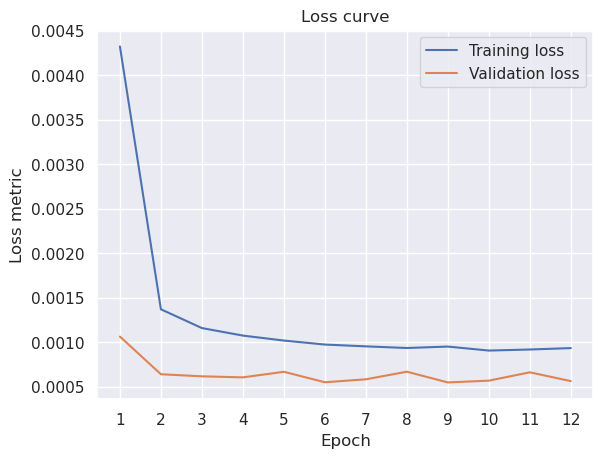

In [49]:
plot_loss_curve()

In [50]:
lstm_trainer.test(lstm_ts_model, dataloaders=pollution_loader.test_dataloader())

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0007515611941926181
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0007515611941926181}]

#### GRU

In [36]:
L.seed_everything(42, workers=True)
gru_model = GRUModel(in_size=8, h_size=4, num_l=8, out_f=1, dropout_rate=0.2).to(device)
gru_ts_model = TSModel(gru_model, lr=0.0157)

gru_trainer = L.Trainer(max_epochs=20, enable_checkpointing=False)
gru_trainer.fit(gru_ts_model, datamodule=pollution_loader)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | GRUModel | 1.0 K 
-----------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


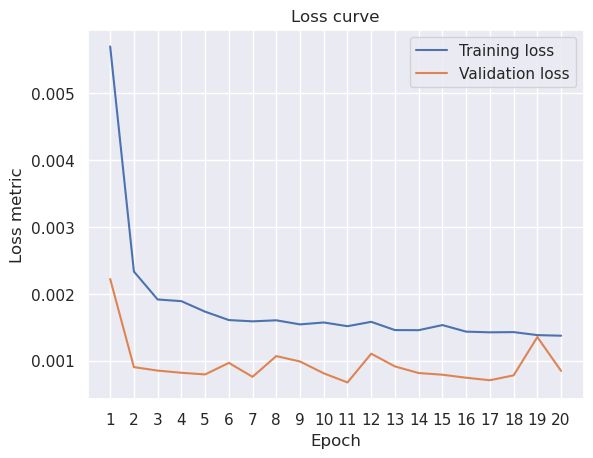

In [37]:
plot_loss_curve()

In [38]:
gru_trainer.test(gru_ts_model, dataloaders=pollution_loader.test_dataloader())

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0010606260038912296
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0010606260038912296}]

#### Prediction

In [59]:
def get_predictions(model, trainer):
    preds = trainer.predict(model, dataloaders=pollution_loader.test_dataloader())
    preds = pollution_loader.y_scaler.inverse_transform(torch.cat(preds))

    return preds

def evaluate_pred(model, trainer):
    preds = get_predictions(model, trainer)
    mse_val = mean_squared_error(pollution_test_df['pollution'], preds)
    mae_val = mean_absolute_error(pollution_test_df['pollution'], preds)
    mape_val = mean_absolute_percentage_error(pollution_test_df['pollution'].map(lambda x: x+0.1), preds)

    return mse_val, mae_val, mape_val

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

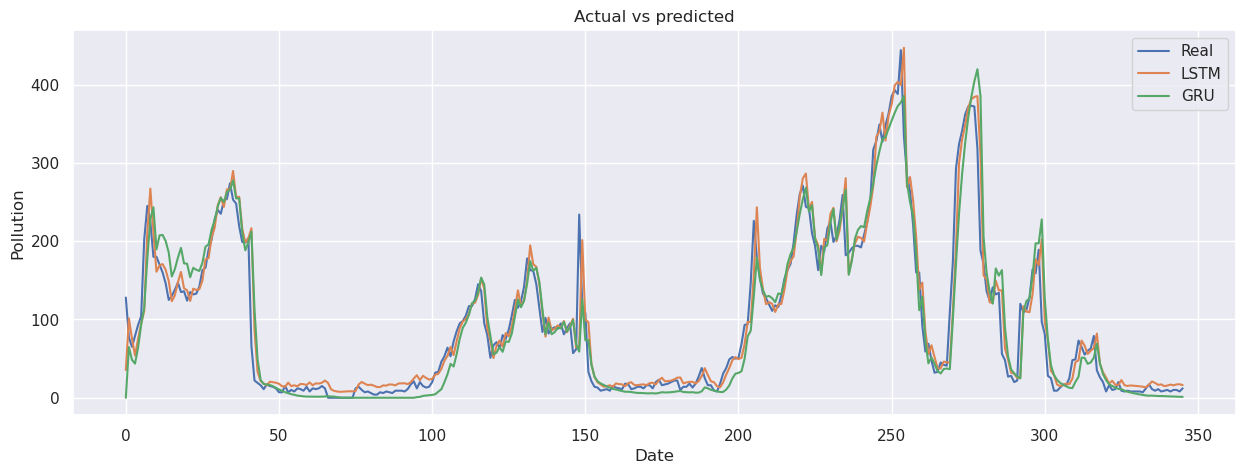

In [51]:
plt.figure(figsize=(15,5))
plt.ylabel("Pollution")
plt.xlabel("Date")
plt.plot(pollution_test_df['pollution'], label="Real")
plt.plot(get_predictions(lstm_ts_model, lstm_trainer), label="LSTM")
plt.plot(get_predictions(gru_ts_model, gru_trainer), label="GRU")
plt.title("Actual vs predicted")
plt.legend()
plt.show()

### Compare models

In [60]:
lstm_mse_val, lstm_mae_val, lstm_mape_val = evaluate_pred(lstm_ts_model, lstm_trainer)
gru_mse_val, gru_mae_val, gru_mape_val = evaluate_pred(gru_ts_model, gru_trainer)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

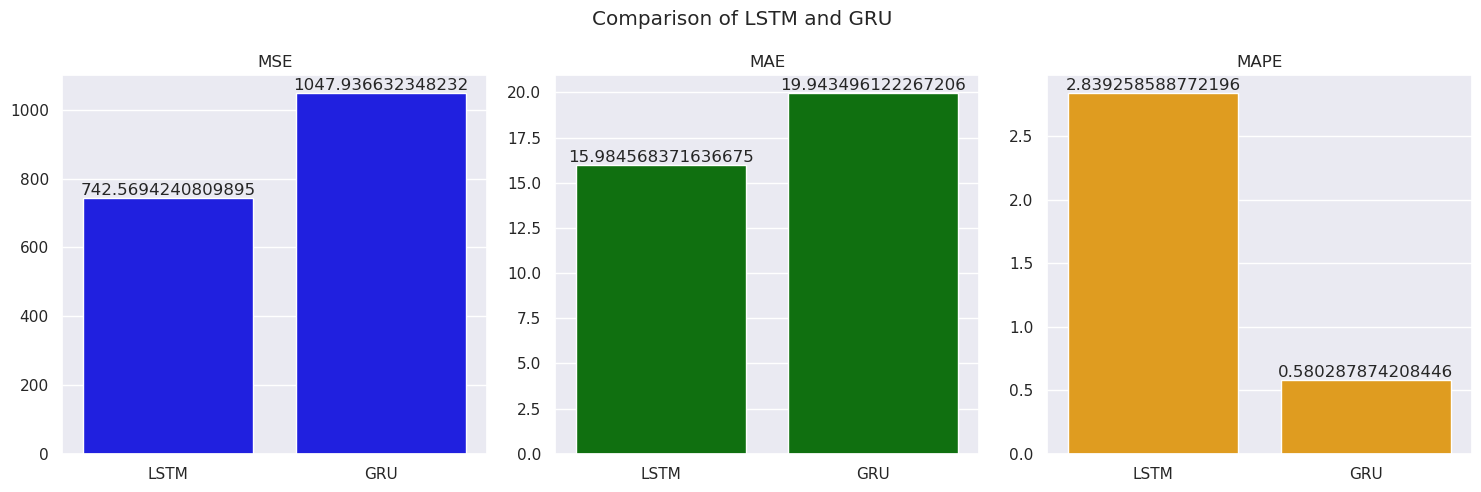

In [61]:
model_names = ["LSTM", "GRU"]
mse_values = [lstm_mse_val, gru_mse_val]
mae_values = [lstm_mae_val, gru_mae_val]
mape_values = [lstm_mape_val, gru_mape_val]

# Create separate subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MSE subplot
mse_bars = sn.barplot(x=model_names, y=mse_values, ax=axes[0], color="blue")
axes[0].set_title("MSE")

# Annotate
for bar, val in zip(mse_bars.patches, mse_values):
    mse_bars.annotate(f'{val}', (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='bottom')

# MAE subplot
mae_bars = sn.barplot(x=model_names, y=mae_values, ax=axes[1], color="green")
axes[1].set_title("MAE")

# Annotate
for bar, val in zip(mae_bars.patches, mae_values):
    mae_bars.annotate(f'{val}', (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='bottom')

# MAPE subplot
mape_bars = sn.barplot(x=model_names, y=mape_values, ax=axes[2], color="orange")
axes[2].set_title("MAPE")

# Annotate
for bar, val in zip(mape_bars.patches, mape_values):
    mape_bars.annotate(f'{val}', (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='bottom')

plt.suptitle("Comparison of LSTM and GRU")
plt.tight_layout()
plt.show()